<a href="https://colab.research.google.com/github/astrodeepnet/sbi_experiments/blob/main/notebooks/ffjord/pure_jax_ode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet dm-haiku optax

     |████████████████████████████████| 287 kB 7.1 MB/s 
     |████████████████████████████████| 126 kB 76.5 MB/s 
     |████████████████████████████████| 65 kB 4.7 MB/s 


In [2]:
import jax
from jax.experimental.ode import odeint
import jax.numpy as jnp
import haiku as hk
import tensorflow_probability as tfp; tfp = tfp.substrates.jax

tfd = tfp.distributions
tfb = tfp.bijectors 
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


## Define simple ode stuff

In [3]:
# Define the ODE
def f(y, t):
  return y

def trace_jacobian_fn(y, t):
  return jnp.trace(jax.jacobian(f)(y,t))

def func(state, t):
  """ Augmented state is [z, trjac]
  """
  z, logdet = state

  dz   = f(z, t)
  djac = trace_jacobian_fn(z, t)
  
  return [dz, djac]

In [4]:
def inv_func(state, t):
  res = func(state, 1.0 - t)
  return -res[0], res[1]

In [5]:
init_state = (jnp.zeros(2), 0.)
vmapped_ode = jax.vmap(lambda x: odeint(func, (x, 0.), jnp.linspace(0.,1.,10)))
vmapped_ode_inv = jax.vmap(lambda x: odeint(inv_func, (x, 0.), jnp.linspace(0.,1.,10)))

In [6]:
dist = tfd.MultivariateNormalDiag(jnp.zeros(2), scale_identity_multiplier=1.)
samples = dist.sample(1000, seed=jax.random.PRNGKey(9))
res = vmapped_ode(samples)

In [7]:
rec = vmapped_ode_inv(res[0][:,-1])

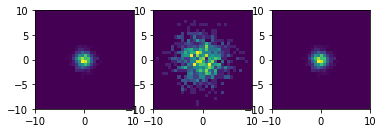

In [8]:
subplot(131)
hist2d(res[0][:,0,0], res[0][:,0,1],32,range=[[-10,10],[-10,10]]);
gca().set_aspect('equal')

subplot(132)
hist2d(res[0][:,-1,0], res[0][:,-1,1],32,range=[[-10,10],[-10,10]]);
gca().set_aspect('equal')

subplot(133)
hist2d(rec[0][:,-1,0], rec[0][:,-1,1],32,range=[[-10,10],[-10,10]]);
gca().set_aspect('equal')

In [9]:
# Let's try to evaluate the logp of the distribution
x,y = jnp.meshgrid(jnp.linspace(-10,10,32), jnp.linspace(-10,10,32))
c = jnp.stack([x,y], axis=-1)

In [10]:
r = vmapped_ode_inv(c.reshape([-1,2]))

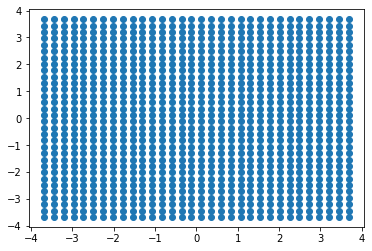

In [11]:
scatter(r[0][:,-1,0], r[0][:,-1,1])

In [12]:
10/r[0][:,-1][0,0]

DeviceArray(-2.7182837, dtype=float32)

In [13]:
logprob = dist.log_prob(r[0][:,-1]) - r[1][:,-1]

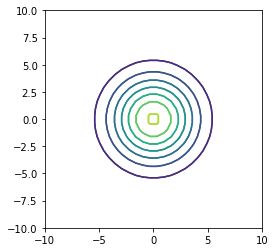

In [14]:
contour(x,y,jnp.exp(logprob.reshape((32,32))));
contour(x,y,jnp.exp(tfd.MultivariateNormalDiag(jnp.zeros(2), scale_identity_multiplier=2.7182827).log_prob(c)))
gca().set_aspect('equal')

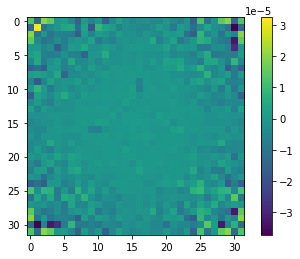

In [15]:
imshow(logprob.reshape(32,32) - tfd.MultivariateNormalDiag(jnp.zeros(2), scale_identity_multiplier=2.7182827).log_prob(c)); colorbar()

In [16]:
# Let's try to compute the score now
def log_prob(x):
  z, detla_logp = odeint(inv_func, (x, 0.), jnp.linspace(0.,1.,10))
  logp = dist.log_prob(z[-1]) - detla_logp[-1]
  return logp

score_fn = jax.jit(jax.vmap(jax.grad(log_prob)))
log_prob_fn = jax.jit(jax.vmap(log_prob))

In [17]:
lp = log_prob_fn(c.reshape([-1,2]))

In [18]:
s = score_fn(c.reshape([-1,2]))

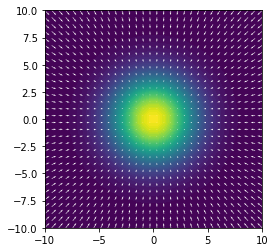

In [19]:
contourf(x,y, jnp.exp(lp.reshape(32,32)),64);
gca().set_aspect('equal')
quiver(x.flatten(), y.flatten(), s[:,0], s[:,1], color='white')

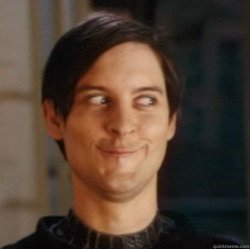

## Now add a neural network in the mix

In [72]:
class MLP(hk.Module):
  """This is a NN that defines the dynamics of the ODE."""
  def __call__(self, x):
    net = hk.Linear(128)(x)
    net = jnp.sin(net)
    net = hk.Linear(128)(net)
    net = jnp.sin(net)
    net = hk.Linear(2)(net)
    return net.squeeze()

siren = hk.without_apply_rng(hk.transform(lambda x,t : MLP()(x)))

rng_seq = hk.PRNGSequence(12)
params = siren.init(next(rng_seq), jnp.zeros([1, 2]), jnp.zeros(1))

In [73]:
# Define the ODE
def f(y, t, params):
  return siren.apply(params, y, t)

def trace_jacobian_fn(y, t, params):
  return jnp.trace(jax.jacobian(f)(y,t, params))

def func(state, t, params):
  """ Augmented state is [z, trjac]
  """
  z, logdet = state

  dz   = f(z, t, params)
  djac = trace_jacobian_fn(z, t, params)
  
  return [dz, djac]

def inv_func(state, t, params):
  res = func(state, 1.0 - t, params)
  return -res[0], res[1]

In [74]:
init_state = (jnp.zeros(2), 0.)
vmapped_ode = jax.vmap(lambda x, p: odeint(func, (x, 0.), jnp.linspace(0.,1.,10), p), in_axes=[0, None])
vmapped_ode_inv = jax.vmap(lambda x, p: odeint(inv_func, (x, 0.), jnp.linspace(0.,1.,10), p), in_axes=[0, None])

In [75]:
res = vmapped_ode(samples, params)
rec = vmapped_ode_inv(res[0][:,-1], params)

In [76]:
res[0].shape

(1000, 10, 2)

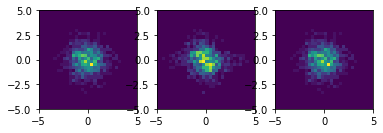

In [77]:
subplot(131)
hist2d(res[0][:,0,0], res[0][:,0,1],32,range=[[-5,5],[-5,5]]);
gca().set_aspect('equal')

subplot(132)
hist2d(res[0][:,-1,0], res[0][:,-1,1],32,range=[[-5,5],[-5,5]]);
gca().set_aspect('equal')

subplot(133)
hist2d(rec[0][:,-1,0], rec[0][:,-1,1],32,range=[[-5,5],[-5,5]]);
gca().set_aspect('equal')

In [78]:
x,y = jnp.meshgrid(jnp.linspace(-5,5,32), jnp.linspace(-5,5,32))
c = jnp.stack([x,y], axis=-1)

In [79]:
def log_prob(x, p):
  z, detla_logp = odeint(inv_func, (x, 0.), jnp.linspace(0.,1.,10), p)
  logp = dist.log_prob(z[-1]) - detla_logp[-1]
  return logp

score_fn = jax.vmap(jax.grad(log_prob), in_axes=[0,None])
log_prob_fn = jax.vmap(log_prob, in_axes=[0,None] )

In [80]:
lp = log_prob_fn(c.reshape([-1,2]), params)
s = score_fn(c.reshape([-1,2]), params)

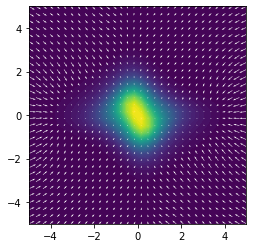

In [81]:
contourf(x,y, jnp.exp(lp.reshape(32,32)),64);
gca().set_aspect('equal')
quiver(x.flatten(), y.flatten(), s[:,0], s[:,1], color='white')

Very cool! looks like it works great!

Let's see if we can train the network

In [82]:
def get_two_moons(sigma, resolution=1024, normalized=False):

  """
  Generate a TFP approximate distribution of the two moons dataset
  Parameters
  ----------
  sigma: float
    Spread of the 2 moons distribution.
  resolution: int
    Number of components in the gaussian mixture approximation of the
    distribution (default: 1024)
  normalized: bool
    Whether to recenter the distribution on [0,1]
  Returns
  -------
  distribution: TFP distribution
    Two moons distribution
  """

  outer_circ_x = jnp.cos(jnp.linspace(0, jnp.pi, resolution))
  outer_circ_y = jnp.sin(jnp.linspace(0, jnp.pi, resolution))
  inner_circ_x = 1 - jnp.cos(jnp.linspace(0, jnp.pi, resolution))
  inner_circ_y = 1 - jnp.sin(jnp.linspace(0, jnp.pi, resolution)) - .5

  X = jnp.append(outer_circ_x, inner_circ_x)
  Y = jnp.append(outer_circ_y, inner_circ_y)

  coords = jnp.vstack([X,Y])
  if normalized:
    coords = coords / 5 + 0.45

  distribution = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=jnp.ones(2*resolution) / resolution / 2),
    components_distribution=tfd.MultivariateNormalDiag(loc=coords.T, scale_identity_multiplier=sigma)
  )
  return distribution

In [117]:
two_moons = get_two_moons(0.1)

In [118]:
import optax

learning_rate=0.001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

In [119]:
def loss_fn(params, batch):
  return - log_prob_fn(batch, params).mean()

@jax.jit
def update(params, opt_state, batch):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)

    return loss, new_params, new_opt_state

In [120]:
from tqdm import tqdm
losses = []
master_seed = hk.PRNGSequence(0)

In [ ]:
for step in tqdm(range(1000)):
  batch = two_moons.sample(128, next(master_seed))
  l, params, opt_state = update(params, opt_state, batch)
  losses.append(l)

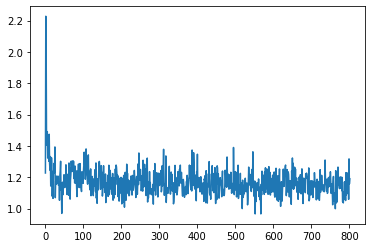

In [122]:
plot(losses)

In [124]:
x,y = jnp.meshgrid(jnp.linspace(-1.5,2.5,32), jnp.linspace(-1,1.5,32))
c = jnp.stack([x,y], axis=-1)

x2,y2 = jnp.meshgrid(jnp.linspace(-1.5,2.5,128), jnp.linspace(-1,1.5,128))
c2 = jnp.stack([x2,y2], axis=-1)

In [125]:
lp = log_prob_fn(c2.reshape([-1,2]), params)
s = score_fn(c.reshape([-1,2]), params)

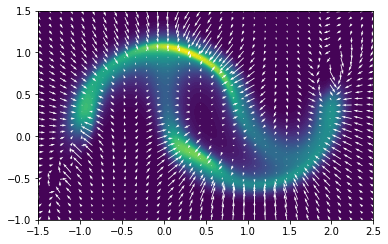

In [126]:
contourf(x2,y2, jnp.exp(lp.reshape(128,128)),64);
gca().set_aspect('equal')
quiver(x.flatten(), y.flatten(), s[:,0], s[:,1], color='white')

## Final test, try to train with score!

In [127]:
@jax.jit
def sample_batch(key):
  x = two_moons.sample(128, seed=key)
  score = jax.vmap(jax.grad(two_moons.log_prob))(x)
  return x, score

In [131]:
from tqdm import tqdm
losses = []
master_seed = hk.PRNGSequence(0)

siren = hk.without_apply_rng(hk.transform(lambda x,t : MLP()(x)))

rng_seq = hk.PRNGSequence(12)
params = siren.init(next(rng_seq), jnp.zeros([1, 2]), jnp.zeros(1))

In [163]:
learning_rate=0.0002
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

In [164]:
def loss_fn(params, batch, score):
  return jnp.sum((score_fn(batch, params) - score)**2, axis=-1).mean()

@jax.jit
def update(params, opt_state, batch, score):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params, batch, score)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)

    return loss, new_params, new_opt_state

In [ ]:
for step in tqdm(range(1000)):
  batch, score = sample_batch(next(master_seed))
  l, params, opt_state = update(params, opt_state, batch, score)
  losses.append(l)

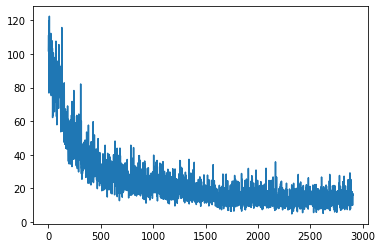

In [172]:
plot(losses)

In [173]:
x,y = jnp.meshgrid(jnp.linspace(-1.5,2.5,32), jnp.linspace(-1,1.5,32))
c = jnp.stack([x,y], axis=-1)

x2,y2 = jnp.meshgrid(jnp.linspace(-1.5,2.5,128), jnp.linspace(-1,1.5,128))
c2 = jnp.stack([x2,y2], axis=-1)

In [174]:
lp = log_prob_fn(c2.reshape([-1,2]), params)
s = score_fn(c.reshape([-1,2]), params)

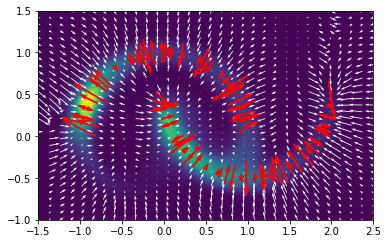

In [175]:
contourf(x2,y2, jnp.exp(lp.reshape(128,128)),64);
gca().set_aspect('equal')
quiver(x.flatten(), y.flatten(), s[:,0], s[:,1], color='white')

quiver(batch[:,0], batch[:,1], score[:,0], score[:,1], color='red')

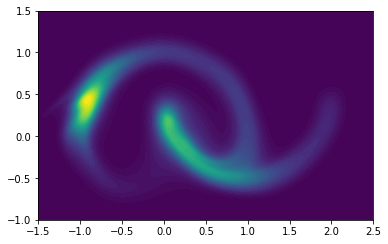

In [176]:
contourf(x2,y2, jnp.exp(lp.reshape(128,128)),64);
gca().set_aspect('equal')